In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [4]:
data_path = 'creditcard.csv'
df = pd.read_csv(data_path)

In [5]:
# Next we will split the new dataset into Features and Target
X = df.drop(columns="Class", axis=1)
y = df["Class"]

In [6]:
X.shape

(284807, 30)

In [7]:
y.shape

(284807,)

In [8]:
# Split the new dataset into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)

print("Training sets:\nX_train: {} y_train:{}".format(X_train.shape, y_train.shape))
print("\nTesting sets:\nX_test: {} y_test:{}".format(X_test.shape, y_test.shape))

Training sets:
X_train: (227845, 30) y_train:(227845,)

Testing sets:
X_test: (56962, 30) y_test:(56962,)


In [9]:
# fit the scaler on the entire data frame so that it standardizes all of the data in the same way. 
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression as the classification algorithm.

In [10]:
# We will use the SMOTE sampling technique, because the basic implementation of SMOTE will not make any distinction 
# between easy and hard samples to be classified using the nearest neighbors rule.
# https://imbalanced-learn.org/stable/common_pitfalls.html

model = make_pipeline(SMOTE(random_state=0), LogisticRegression())

In [11]:
cv_results = cross_validate(model, X_train, y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True, n_jobs=-1)
    
print(f"Balanced accuracy mean:" f"{cv_results['test_score'].mean():.3f}")    

Balanced accuracy mean:0.948


In [12]:
accuracy_scores = []
f1_scores = []
auc_scores = []

for fold_id, cv_model in enumerate(cv_results["estimator"]):
    
    y_pred = cv_model.predict(X_test)
    
    accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # predict probabilities    
    y_probs = cv_model.predict_proba(X_test)
    y_probs = y_probs[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    auc_scores.append(auc(recall, precision))

# summarize scores
print(f"Balanced accuracy mean:" f"{np.mean(accuracy_scores):.3f}")

print('Logistic: f1 score=%.3f auc score=%.3f' % (np.mean(f1_scores), np.mean(auc_scores)))    

Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739


# Hyperparameter tuning

In [13]:
# Tune Hyperparameters for Classification Machine Learning Algorithms 
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
#solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [15]:
for C in c_values:
    
    model = make_pipeline(SMOTE(random_state=0), LogisticRegression(C=C))
    
    cv_results = cross_validate(model, X_train, y_train, scoring="balanced_accuracy",
    return_train_score=True, return_estimator=True, n_jobs=-1)
    
    accuracy_scores = []
    f1_scores = []
    auc_scores = []

    for fold_id, cv_model in enumerate(cv_results["estimator"]):
        
        y_pred = cv_model.predict(X_test)

        accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # predict probabilities    
        y_probs = cv_model.predict_proba(X_test)
        y_probs = y_probs[:, 1]
    
        precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

        auc_scores.append(auc(recall, precision))
        
    print(f"C:" f"{C:.3f}")
    print(f"Balanced accuracy mean:" f"{np.mean(accuracy_scores):.3f}")
    print('Logistic: f1 score=%.3f auc score=%.3f' % (np.mean(f1_scores), np.mean(auc_scores)))    

C:100.000
Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739
C:10.000
Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739
C:1.000
Balanced accuracy mean:0.930
Logistic: f1 score=0.109 auc score=0.739
C:0.100
Balanced accuracy mean:0.931
Logistic: f1 score=0.109 auc score=0.735
C:0.010
Balanced accuracy mean:0.931
Logistic: f1 score=0.111 auc score=0.715


# ROC vs. Precision-Recall Curve

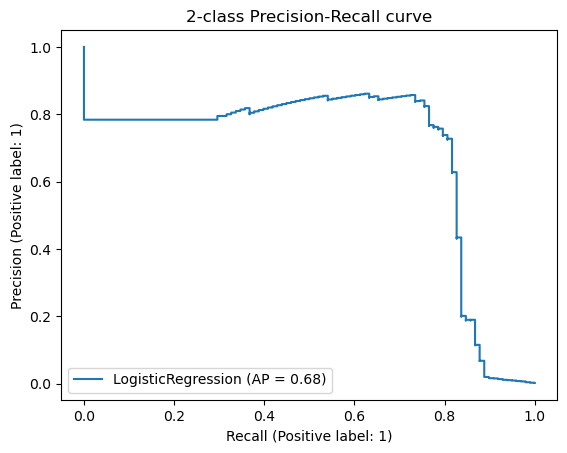

In [16]:
# ROC curves should be used when there are roughly equal numbers of observations for each class.
# Precision-Recall curves should be used when there is a moderate to large class imbalance.
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

display = PrecisionRecallDisplay.from_estimator(
    cv_model, X_test, y_test, name="LogisticRegression")

_ = display.ax_.set_title("2-class Precision-Recall curve")

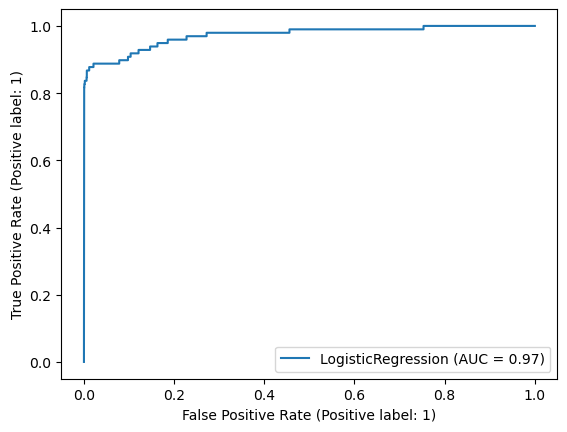

In [17]:
# ROC curve
RocCurveDisplay.from_estimator(cv_model, X_test, y_test, name="LogisticRegression")